In [ ]:
# install dependencies: 
!pip install pyyaml==5.1
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())
!gcc --version
# opencv is pre-installed on colab

# install detectron2: (Colab has CUDA 10.1 + torch 1.7)
# See https://detectron2.readthedocs.io/tutorials/install.html for instructions
import torch
assert torch.__version__.startswith("1.7")
!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.7/index.html
# exit(0)  # After installation, you need to "restart runtime" in Colab. This line can also restart runtime
#!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.7/index.html

     |████████████████████████████████| 276kB 11.3MB/s 
  Created wheel for pyyaml: filename=PyYAML-5.1-cp36-cp36m-linux_x86_64.whl size=44075 sha256=77d0896a6e522fb12b053aaf2a485d913fbeea159640d77273ac3808d4f0b43e
  Stored in directory: /root/.cache/pip/wheels/ad/56/bc/1522f864feb2a358ea6f1a92b4798d69ac783a28e80567a18b
Successfully built pyyaml
  Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
1.7.0+cu101 True
gcc (Ubuntu 7.5.0-3ubuntu1~18.04) 7.5.0
Copyright (C) 2017 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.

Looking in links: https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.7/index.html
     |████████████████████████████████| 6.8MB 102.8MB/s 
     |████████████████████████████████| 2.2MB 24.3MB/s 
  Created wheel for fvcore: filename=fvcore-0.1.2.post20210128-cp36-non

In [ ]:
import torch, torchvision
import torch
assert torch.__version__.startswith("1.7")

In [ ]:
#import torch
#assert torch.__version__.startswith("1.7")
#!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.7/index.html
# exit(0)  # After installation, you need to "restart runtime" in Colab. This line can also restart runtime

In [ ]:
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

import pandas as pd
import scipy.io as sio
import os
from matplotlib import pyplot as plt

** fvcore version of PathManager will be deprecated soon. **
** Please migrate to the version in iopath repo. **
https://github.com/facebookresearch/iopath 

** fvcore version of PathManager will be deprecated soon. **
** Please migrate to the version in iopath repo. **
https://github.com/facebookresearch/iopath 



In [ ]:
!wget http://vision.soic.indiana.edu/egohands_files/egohands_data.zip
!unzip egohands_data.zip > /dev/null

--2021-01-30 10:21:45--  http://vision.soic.indiana.edu/egohands_files/egohands_data.zip
Resolving vision.soic.indiana.edu (vision.soic.indiana.edu)... 156.56.83.21
Connecting to vision.soic.indiana.edu (vision.soic.indiana.edu)|156.56.83.21|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1332784625 (1.2G) [application/zip]
Saving to: ‘egohands_data.zip’

egohands_data.zip   100%[===================>]   1.24G  26.7MB/s    in 52s     

2021-01-30 10:22:39 (24.3 MB/s) - ‘egohands_data.zip’ saved [1332784625/1332784625]



In [ ]:
BASE_PATH = '_LABELLED_SAMPLES/'

In [ ]:
folders = sorted(os.listdir('_LABELLED_SAMPLES'))

In [ ]:
folder_names = []
image_names = []
polygons_master = []

In [ ]:
for folder in folders:
    img_names = sorted([x for x in os.listdir(BASE_PATH + folder) if x.split('.')[-1] == 'jpg'])
    poly_file = sio.loadmat(BASE_PATH + folder +'/'+ 'polygons.mat')['polygons'][0]
    i = 0
    for img_name in img_names:
        folder_names.append(folder)
        image_names.append(img_name)
        polygons_master.append(poly_file[i])
        i = i + 1

In [ ]:
df = pd.DataFrame({'folder_name':folder_names,'image_names':image_names,'polygons':polygons_master})

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
train,test = train_test_split(df,test_size=0.2)

In [ ]:
from detectron2.structures import BoxMode

In [ ]:
def get_balloon_dicts(img_dir):
  df = None
  if img_dir == 'train':
    df = train
  else:
    df = test
  
  dataset_dicts = []
  i = 0
  for index, row in df.iterrows():
    i = i + 1
    #print("doing for index "+str(i))
    record = {}

    filename = os.path.join(BASE_PATH + row['folder_name'], row['image_names'])
    #height, width = cv2.imread(filename).shape[:2]

    record["file_name"] = filename
    record["image_id"] = row['image_names'].split('.')[0]
    record["height"] = 720
    record["width"] = 1280

    annos = row['polygons']
    objs = []
    
    for hand in annos:
      x_min = 2000
      y_min = 2000
      x_max = -1
      y_max = -1

      #array to hold x and y values of hand pixels
      poly = []

      if hand.size > 0:
        for pixel in hand:
          x = int(pixel[0])
          y = int(pixel[1])
          
          poly.append(x)
          poly.append(y)
          
          if  x > x_max:
              x_max = x
          if x < x_min:
              x_min = x
          if y > y_max:
              y_max = y
          if y < y_min:
              y_min = y
          
        #array to corners of bbox
        corners = [x_min,y_min,x_max,y_max]

        obj = {
              "bbox": corners,
              "bbox_mode": BoxMode.XYXY_ABS,
              "segmentation": [poly],
              "category_id": 0,
          }
        objs.append(obj)
    record["annotations"] = objs
    dataset_dicts.append(record)
  return dataset_dicts

In [ ]:
for d in ["train", "val"]:
    DatasetCatalog.register("hand_" + d, lambda d=d: get_balloon_dicts(d))
    MetadataCatalog.get("hand_" + d).set(thing_classes=["hand"])
balloon_metadata = MetadataCatalog.get("hand_train")

In [ ]:
dataset_dicts = get_balloon_dicts("train")

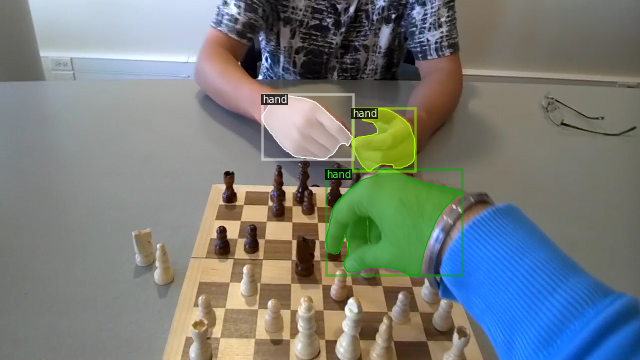

In [ ]:
d = dataset_dicts[150]
img = cv2.imread(d["file_name"])
visualizer = Visualizer(img[:, :, ::-1], metadata=balloon_metadata, scale=0.5)
out = visualizer.draw_dataset_dict(d)
cv2_imshow(out.get_image()[:, :, ::-1])

In [ ]:
from detectron2.engine import DefaultTrainer

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("hand_train",)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.00025  # pick a good LR
cfg.SOLVER.MAX_ITER = 600   # 300 iterations seems good enough for this toy dataset; you will need to train longer for a practical dataset
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128   # faster, and good enough for this toy dataset (default: 512)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  # only has one class (ballon). (see https://detectron2.readthedocs.io/tutorials/datasets.html#update-the-config-for-new-datasets)
# NOTE: this config means the number of classes, but a few popular unofficial tutorials incorrect uses num_classes+1 here.

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=False)
trainer.train()

[01/30 10:33:23 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (2, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (2,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (4, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (4,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.mask_head.predictor.weight' to the model due to incompatible shapes: (80, 256, 1, 1) in the checkpoint but (1, 256, 1, 1) in

[01/30 10:33:26 d2.engine.train_loop]: Starting training from iteration 0
[01/30 10:33:32 d2.utils.events]:  eta: 0:03:08  iter: 19  total_loss: 2.074  loss_cls: 0.6779  loss_box_reg: 0.6025  loss_mask: 0.6895  loss_rpn_cls: 0.06929  loss_rpn_loc: 0.0202  time: 0.3210  data_time: 0.0172  lr: 4.9953e-06  max_mem: 2670M
[01/30 10:33:39 d2.utils.events]:  eta: 0:03:02  iter: 39  total_loss: 2.086  loss_cls: 0.641  loss_box_reg: 0.6194  loss_mask: 0.6875  loss_rpn_cls: 0.08996  loss_rpn_loc: 0.02217  time: 0.3246  data_time: 0.0053  lr: 9.9902e-06  max_mem: 2670M
[01/30 10:33:45 d2.utils.events]:  eta: 0:02:55  iter: 59  total_loss: 1.939  loss_cls: 0.5743  loss_box_reg: 0.581  loss_mask: 0.6841  loss_rpn_cls: 0.08784  loss_rpn_loc: 0.02486  time: 0.3223  data_time: 0.0048  lr: 1.4985e-05  max_mem: 2670M
[01/30 10:33:52 d2.utils.events]:  eta: 0:02:48  iter: 79  total_loss: 2.073  loss_cls: 0.5489  loss_box_reg: 0.786  loss_mask: 0.6755  loss_rpn_cls: 0.05164  loss_rpn_loc: 0.02101  time: 

In [ ]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  # path to the model we just trained
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7   # set a custom testing threshold
predictor = DefaultPredictor(cfg)

In [ ]:
from detectron2.utils.visualizer import ColorMode
dataset_dicts = get_balloon_dicts("test")

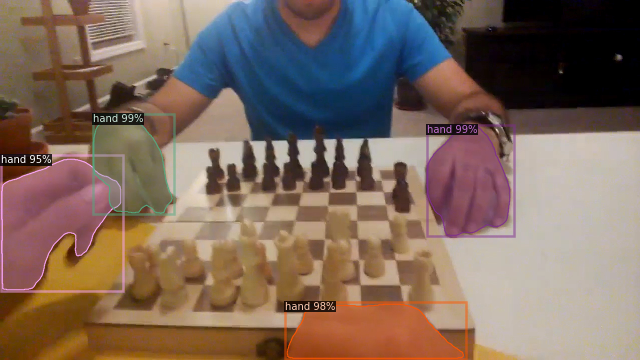

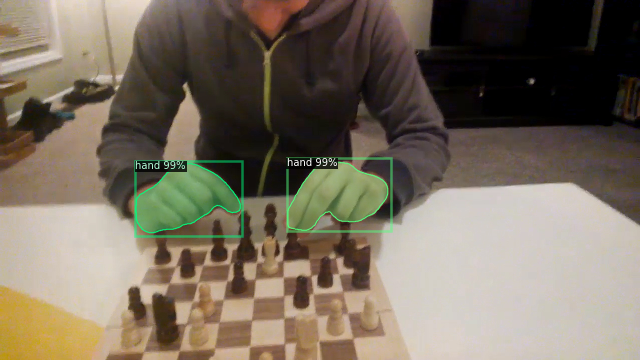

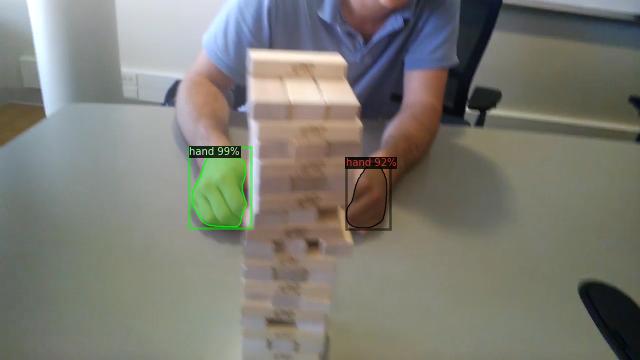

In [ ]:
for d in random.sample(dataset_dicts, 3):    
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)  # format is documented at https://detectron2.readthedocs.io/tutorials/models.html#model-output-format
    v = Visualizer(im[:, :, ::-1],
                   metadata=balloon_metadata, 
                   scale=0.5, 
                   instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels. This option is only available for segmentation models
    )
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    cv2_imshow(out.get_image()[:, :, ::-1])